In [1]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-4.8 cpp-5 gcc-4.8-base gcc-5-base libasan0 libasan2 libgcc-4.8-dev
  libgcc-5-dev libisl15 libmpx0 libstdc++-4.8-dev libstdc++-5-dev
Suggested packages:
  gcc-4.8-locales gcc-5-locales g++-4.8-multilib gcc-4.8-doc
  libstdc++6-4.8-dbg g++-5-multilib gcc-5-doc libstdc++6-5-dbg
  gcc-4.8-multilib libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg
  libasan0-dbg libtsan0-dbg libquadmath0-dbg gcc-5-multilib libasan2-dbg
  liblsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg libstdc++-4.8-doc
  libstdc++-5-doc
The following NEW packages will be installed:
  cpp-4.8 cpp-5 g++-4.8 g++-5 gcc-4.8 gcc-4.8-base gcc-5 gcc-5-base libasan0
  libasan2 libgcc-4.8-dev libgcc-5-dev libisl15 libmpx0 libstdc++-4.8-dev
  libstdc++-5-dev
0 upgraded, 16 newly installed, 0 to remove and 21 not upgraded.
Need to get 58.3 MB of archives.
After this operati

In [2]:
!pip install torch==1.3.0

     |████████████████████████████████| 773.1MB 25kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [3]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

update-alternatives: using /usr/bin/gcc-4.8 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/gcc-5 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/g++-4.8 to provide /usr/bin/g++ (g++) in auto mode
update-alternatives: using /usr/bin/g++-5 to provide /usr/bin/g++ (g++) in auto mode


In [12]:
!git clone https://github.com/mszarski/diffsim.git

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/mszarski/diffsim
 * branch            HEAD       -> FETCH_HEAD
Updating 8592295..635473f
Fast-forward
 arcsim/src/display.cpp | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [5]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [13]:
%cd /content

/content


In [14]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes


/content/diffsim
update-alternatives: using /usr/bin/gcc-4.8 to provide /usr/bin/gcc (gcc) in manual mode
update-alternatives: using /usr/bin/g++-4.8 to provide /usr/bin/g++ (g++) in manual mode
/content/diffsim/arcsim/dependencies
make: Nothing to be done for 'all'.
/content/diffsim
update-alternatives: using /usr/bin/gcc-5 to provide /usr/bin/gcc (gcc) in manual mode
update-alternatives: using /usr/bin/g++-5 to provide /usr/bin/g++ (g++) in manual mode
CXX arcsim/src/display.cpp
g++ arcsim/src/display.cpp -MMD -MP -DFAST_MODE -pthread -fPIC -fwrapv -std=c++11 -DNDEBUG -O3 -I/usr/include/python3.6m -INo -ICUDA -Iruntime -Iis -Ifound, -Iusing -ICUDA_HOME='/usr/local/cuda' -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/lib/python3.6/dist-packages/torch/include/THC -Iarcsim/dependencies/include -Iarcsim/src -DTORCH_API_INCLUDE_EXTENS

In [ ]:
##restart runtime here

In [1]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [33]:
%%writefile conf/draping.json
{
    "frame_time": 0.04,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/2d_shape.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.5]},
        "materials": [{"data": "materials/gray-interlock.json",
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/3d_shape.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "disable":["remeshing"],
    "gravity":[0, 0, -10],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/draping.json


In [ ]:
%%writefile conf/draping.json
{
    "frame_time": 0.04,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/2d_shape.obj",
        "transform":{"scale":0.01,"translate":[0,0,0]},
        "materials": [{"data": "materials/gray-interlock.json",
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/3d_shape.obj",
        "transform":{"scale":0.01,"translate":[0,0,-0.75]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "disable":["remeshing"],
    "gravity":[0, 0, -10],
    "handles": [{"nodes": [243, 86, 19, 62], "end_time": 10}],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/draping.json


In [ ]:
!rm -rf /content/default_out

In [34]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/default_out'

if not os.path.exists(out_path):
	os.mkdir(out_path)

with open('conf/draping.json','r') as f:
	config = json.load(f)

def save_config(config, file):
	with open(file,'w') as f:
		json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
scalev=1

seed_point_index = 166
handles = [243, 86, 19, 62]

def reset_sim(sim, epoch):
	if epoch < 40:
		arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
	else:
		arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)

def run_sim(steps,sim,param_v):

	print("step")
	for step in range(40):
		print(step)
	
		#print(param_v[step])

		# if step < 1:
		# 	for i in range(len(handles)):
		# 		sim.cloths[0].mesh.nodes[handles[i]].v += torch.tensor([0, 0, 0],dtype=torch.float64) 

		for i in range(len(handles)):
			sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step,i] 

		#sim.cloths[0].mesh.nodes[seed_point_index].v += param_v[step]

		print(sim.cloths[0].mesh.nodes[seed_point_index].x)
		print(sim.obstacles[0].curr_state_mesh.nodes[seed_point_index].x)
		
		arcsim.sim_step()

	loss = torch.norm(sim.obstacles[0].curr_state_mesh.nodes[seed_point_index].x - sim.cloths[0].mesh.nodes[seed_point_index].x, p=2)
	reg  = torch.norm(param_v, p=2)*0.001

	total_loss = loss #+ reg

	return total_loss

def do_train(cur_step,optimizer,sim,param_v):
	epoch = 0
	while True:
		steps=10
		reset_sim(sim, epoch)
		st = time.time()
		loss = run_sim(steps, sim, param_v)
		en0 = time.time()
		optimizer.zero_grad()
	
		loss.backward(retain_graph=True)

		en1 = time.time()
		print("=======================================")
		print(param_v.data)
		print(param_v.grad.data)
		f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
		print('epoch {}:  loss={} \n'.format(epoch, loss.data))

		print('forward time={}'.format(en0-st))
		print('backward time={}'.format(en1-en0))

		optimizer.step()
		if epoch>=40:
			break
		epoch = epoch + 1
		# break

with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
	tot_step = 1
	sim=arcsim.get_sim()
	# reset_sim(sim)

	param_v = torch.zeros([40, 4,3],dtype=torch.float64, requires_grad=True)
	#param_v = torch.zeros([20, 3],dtype=torch.float64, requires_grad=True)

	lr = 0.1 *10000
	momentum = 0.4
	f.write('lr={} momentum={}\n'.format(lr,momentum))
	optimizer = torch.optim.SGD([{'params':param_v,'lr':lr}],momentum=momentum)
	# optimizer = torch.optim.Adadelta([density, stretch, bend])
	for cur_step in range(tot_step):
		do_train(cur_step,optimizer,sim,param_v)

print("done")


Streaming output truncated to the last 5000 lines.
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
24
tensor([-0.0127, -0.2878, -0.2012], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
25
tensor([-0.0018, -0.3010, -0.2397], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
26
tensor([ 0.0118, -0.3147, -0.2786], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
27
tensor([ 0.0274, -0.3344, -0.2845], dtype=torch.float64,
       grad_fn=<SliceBackward>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
28
tensor([ 0.0397, -0.3578, -0.2833], dtype=torch.float64,
       grad_fn=<SliceBackward>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
29
tensor([ 0.0568, -0.3807, -0.2792], dtype=torch.float64,
       grad_fn=<SliceBackward>)
tensor([ 0.4518, -0.8830, -0.3937], dtype=torch.float64)
3

KeyboardInterrupt: ignored

In [3]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/default_out/out12', '/content/default_out/out12'])
print(prof)

Overwriting visualize.py


In [3]:
!xvfb-run -s "-screen 0 1280x720x24 -ac +extension GLX +render -noreset" python visualize.py

main
4
arcsim replay /content/default_out/out12
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/default_out/out12/0000_
/content/default_out/out12/0000_rig
reply 7 
/content/default_out/out12/0000.bmp
/content/default_out/out12/0001_
/content/default_out/out12/0001_rig
/content/default_out/out12/0001.bmp
/content/default_out/out12/0002_
/content/default_out/out12/0002_rig
/content/default_out/out12/0002.bmp
/content/default_out/out12/0003_
/content/default_out/out12/0003_rig
/content/default_out/out12/0003.bmp
/content/default_out/out12/0004_
/content/default_out/out12/0004_rig
/content/default_out/out12/0004.bmp
/content/default_out/out12/0005_
/content/default_out/out12/0005_rig
/content/default_out/out12/0005.bmp
/content/default_out/out12/0006_
/content/default_out/out12/0006_rig
/content/default_out/out12/0006.bmp
/content/default_out/out12/0007_
/content/default_out/out12/0007_rig
/content/default_out/out12/0007.bmp
/content/default_out/out12/0008_
/content/default

In [4]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path('/content/default_out/out12').glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    

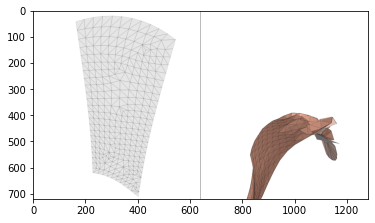

In [5]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [6]:
ani.save('diffdrape.mp4')